In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import io
import matplotlib.pyplot as plt

In [9]:
# Загрузите датасет
dataset_path = "/kaggle/input/allphoto/combined_file.csv"  # Замените на ваш путь к CSV-файлу
data = pd.read_csv(dataset_path)


print(data.head())

                                                 url  label  Unnamed: 0
0  //avatars.mds.yandex.net/get-realty-offers/136...      5         NaN
1  //avatars.mds.yandex.net/get-realty-offers/988...      5         NaN
2  //avatars.mds.yandex.net/get-realty-offers/127...      5         NaN
3  //avatars.mds.yandex.net/get-realty-offers/138...      5         NaN
4  //avatars.mds.yandex.net/get-realty-offers/101...      5         NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7203 entries, 0 to 7202
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         7203 non-null   object 
 1   label       7203 non-null   int64  
 2   Unnamed: 0  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 168.9+ KB


In [11]:
data.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,label,Unnamed: 0
count,7203.000000,0.0
mean,2.487297,NaN
std,1.844390,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,3.000000,NaN
75%,4.000000,NaN
max,5.000000,NaN


In [12]:
data.head(0)

,url,label,Unnamed: 0


In [13]:
data = data.drop('Unnamed: 0',axis=1 )

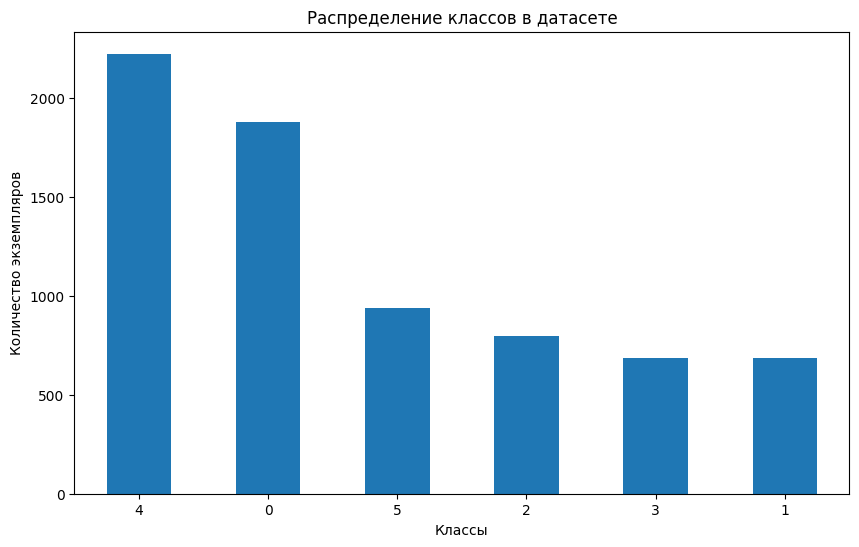

In [14]:
import pandas as pd


class_counts = data['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Распределение классов в датасете')
plt.xlabel('Классы')
plt.ylabel('Количество экземпляров')
plt.xticks(rotation=0)  # Установка меток по оси X без наклона
plt.show()


In [15]:
import pandas as pd

classes_to_reduce = [4, 5]


reduction_factor1 = 0.5 
reduction_factor2 = 0.7


balanced_df = pd.DataFrame()

for class_label in classes_to_reduce:

    class_data = data[data['label'] == class_label]

    if class_label == 4:
        num_to_keep = int(len(class_data) * (1 - reduction_factor2))
    else:
        num_to_keep = int(len(class_data) * (1 - reduction_factor1))

    reduced_class_data = class_data.sample(num_to_keep, random_state=42)  # random_state для воспроизводимости


    balanced_df = pd.concat([balanced_df, reduced_class_data])


other_classes = data[~data['label'].isin(classes_to_reduce)]
balanced_df = pd.concat([balanced_df, other_classes])


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


print(balanced_df['label'].value_counts())

label
0    1876
2     796
3     687
1     684
4     666
5     469
Name: count, dtype: int64


In [16]:
balanced_df = balanced_df[balanced_df["label"] != 0]  

In [17]:
print(balanced_df['label'].value_counts())

label
2    796
3    687
1    684
4    666
5    469
Name: count, dtype: int64


In [18]:
import pandas as pd
import concurrent.futures
import requests

def get_image(url):

    if ("https:" not in url):
        url = "https:" + url
    try:
        response = requests.get(url)
        response.raise_for_status()  # Проверка на ошибки
        return response.content  
    except Exception as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return None

def load_images_with_labels(data, url_column='url', label_column='label', num_thread=5, batch_size=100):
    images = []
    image_labels = []

    urls = data[url_column].tolist()  # Получаем список URL из DataFrame
    labels = data[label_column].tolist() if label_column in data.columns else [None] * len(urls)  # Получаем список меток из DataFrame, если есть

    # Разбиваем на пакеты
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_thread) as executor:
            future_to_url = {executor.submit(get_image, url): (url, label) for url, label in zip(batch_urls, batch_labels)}

            for future in concurrent.futures.as_completed(future_to_url):
                url, label = future_to_url[future]
                try:
                    image = future.result()
                    if image:
                        images.append(image)
                        image_labels.append(label)
                except Exception as e:
                    print(f"Ошибка при обработке {url}: {e}")

    return images, image_labels


images, image_labels = load_images_with_labels(balanced_df)



In [20]:
data = balanced_df

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


images_tensor = []
for img_bytes in images:
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    img_tensor = transform(img)
    images_tensor.append(img_tensor)

images_tensor = torch.stack(images_tensor)


In [22]:
num_classes = len(data['label'].unique())


model = models.efficientnet_b0(pretrained=True)

# Замените последний слой для вашей задачи классификации
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 172MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [23]:
image_labels = [label - 1 for label in image_labels]

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


model.train()
num_epochs = 30
for epoch in range(num_epochs):
    for i in range(len(images_tensor)):
        inputs = images_tensor[i].unsqueeze(0).to(device)
        target = torch.tensor(image_labels[i], dtype=torch.long).unsqueeze(0).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/30], Loss: 1.6848
Epoch [2/30], Loss: 1.4332
Epoch [3/30], Loss: 1.4148
Epoch [4/30], Loss: 1.3189
Epoch [5/30], Loss: 1.3860
Epoch [6/30], Loss: 1.1771
Epoch [7/30], Loss: 1.2092
Epoch [8/30], Loss: 1.3526
Epoch [9/30], Loss: 1.3397
Epoch [10/30], Loss: 1.6701
Epoch [11/30], Loss: 1.7178
Epoch [12/30], Loss: 1.6339
Epoch [13/30], Loss: 1.4270
Epoch [14/30], Loss: 1.3046
Epoch [15/30], Loss: 0.7568
Epoch [16/30], Loss: 0.8732
Epoch [17/30], Loss: 0.9645
Epoch [18/30], Loss: 1.6267
Epoch [19/30], Loss: 1.0272
Epoch [20/30], Loss: 0.7270
Epoch [21/30], Loss: 0.6640
Epoch [22/30], Loss: 0.2085
Epoch [23/30], Loss: 2.8721
Epoch [24/30], Loss: 0.4341
Epoch [25/30], Loss: 2.0013
Epoch [26/30], Loss: 0.5002
Epoch [27/30], Loss: 0.1484
Epoch [28/30], Loss: 2.1618
Epoch [29/30], Loss: 0.1065
Epoch [30/30], Loss: 0.8853


In [24]:
import torch
from sklearn.metrics import classification_report


model.eval()  
all_predictions = []
all_labels = []

with torch.no_grad(): 
    for i in range(len(images_tensor)):
        inputs = images_tensor[i].unsqueeze(0).to(device)
        target = image_labels[i] 

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) 

        all_predictions.append(predicted.item())
        all_labels.append(target)


report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.25      0.53      0.34       684
     Class 1       0.24      0.26      0.25       796
     Class 2       0.22      0.12      0.16       687
     Class 3       0.54      0.05      0.10       666
     Class 4       0.25      0.27      0.26       469

    accuracy                           0.25      3302
   macro avg       0.30      0.25      0.22      3302
weighted avg       0.30      0.25      0.22      3302



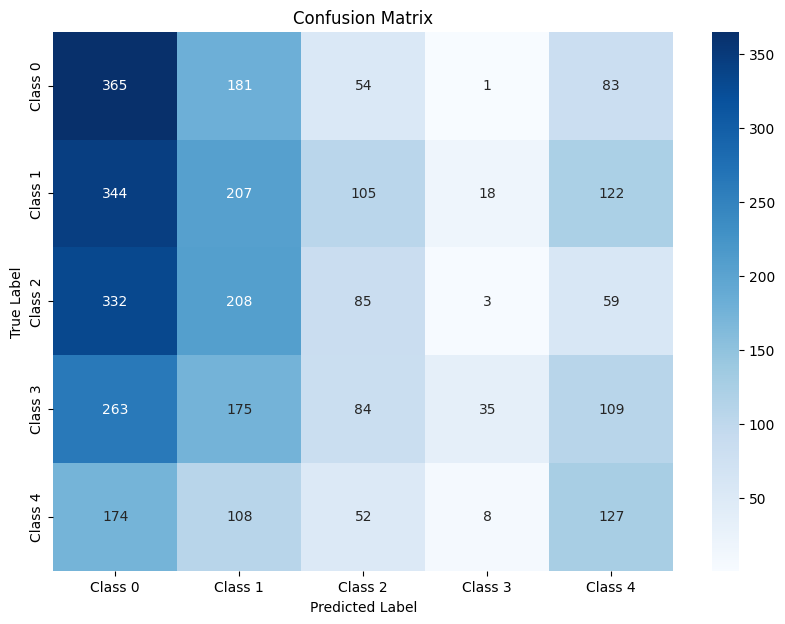

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(5)], yticklabels=[f'Class {i}' for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [27]:
torch.save(model, 'model.pth')

torch.save(model.state_dict(), 'model_state_dict.pth')
